In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [2]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
#df=pd.read_pickle(os.getcwd()+"\\Data Files\\sql_data.pkl")
# qu1= """
# select * from TMP_BD_GRID_DISTANCE_ID
# where risk_agrf120 =1 
# """
#df = pd.read_sql(qu1,connection)
#df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")
#df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.csv")

In [3]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")

In [4]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,RISK_SCORE,RNK
0,154432501,2018-01-02,28.725803,77.175379,0,1,CD,0.027432,1
1,154536129,2018-01-01,25.313181,82.953024,1,1,CD,0.034592,1
2,154536988,2018-01-01,21.320343,72.868642,0,1,CD,0.042080,1
3,154545377,2018-01-01,22.690763,75.828938,0,1,CD,0.008329,1
4,154638596,2018-01-01,22.314938,70.834873,0,1,CD,0.071870,1


In [5]:
df.dropna(subset = ["RISK_SCORE"], inplace = True)

In [6]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df.groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

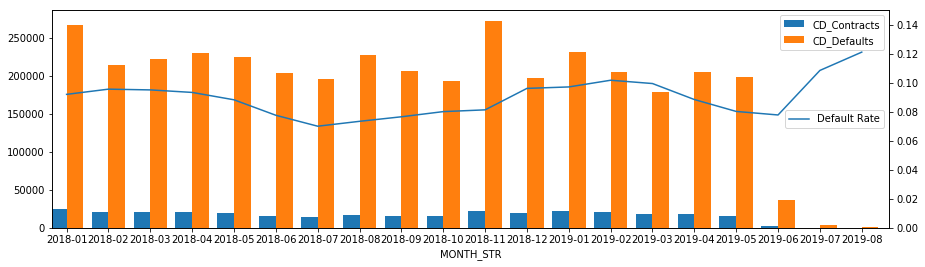

In [7]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [9]:
df_test_final = df_test.head()

In [10]:
df_test_final

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,RISK_SCORE,RNK,MONTH_STR
2868826,223563879,2019-02-01,22.271400,70.779590,1,1,CD,0.015552,1,2019-02
2874185,223672260,2019-02-03,22.758185,86.212367,0,1,CD,0.015991,1,2019-02
2874436,223673200,2019-02-03,30.848835,75.888499,0,1,CD,0.024406,1,2019-02
2875137,223676221,2019-02-04,9.998186,76.397605,1,1,CD,0.011368,1,2019-02
2875564,223678061,2019-02-02,22.296405,70.794156,0,1,CD,0.004911,1,2019-02


In [7]:
df_final_test = pd.DataFrame()

import datetime
from sklearn.neighbors import KNeighborsClassifier

for x in np.arange(1,6,1):
    
    date_train_start = datetime.datetime(2018, x, 1)
    date_train_end = (date_train_start.replace(day=1)).replace(year=2019)
    date_test_end = (date_train_end.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)

    start_time = datetime.datetime.now()
    df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<datetime.datetime(2019, 1, 1))]
    df_test = df[(df["TIME_DECISION_DATE"]>=date_train_end) & 
                  (df["TIME_DECISION_DATE"]<date_test_end)]


    count_class_0, count_class_1 = df_train.RISK_FSTQPD30.value_counts()
    df_class_0 = df_train[df_train['RISK_FSTQPD30'] == 0]
    df_class_1 = df_train[df_train['RISK_FSTQPD30'] == 1]
    df_class_0_under = df_class_0.sample(200000)
    df_class_1_under = df_class_1.sample(200000)
    df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

    X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
    X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

    y_train = df_train_under["RISK_FSTQPD30"]
    y_test =  df_test["RISK_FSTQPD30"]



    knn = KNeighborsClassifier(n_neighbors = 400)
    bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

    ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
    ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    
    df_test['PRED_SCORE'] = ypred_test
    
    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)

    print("Training for predicting (month):",date_train_start.month, "    GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
         "    time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))




C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1     GINI TRAIN: 15.66%     GINI TEST: 12.19%     time taken:  1.2


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2     GINI TRAIN: 15.76%     GINI TEST: 11.82%     time taken:  1.2


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3     GINI TRAIN: 15.66%     GINI TEST: 10.65%     time taken:  1.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4     GINI TRAIN: 15.79%     GINI TEST: 9.99%     time taken:  1.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5     GINI TRAIN: 15.71%     GINI TEST: 10.33%     time taken:  1.2
